In [1]:
!pip install torch==2.2
!pip install torchvision==0.17
!pip install matplotlib==3.5.2
!pip install poutyne==1.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.2/211.2 kB 12.7 MB/s eta 0:00:00


In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne import set_seeds, Model

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-02-16 02:04:56.133404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 02:04:56.133460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 02:04:56.135131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
set_seeds(42)

In [4]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

train_split_percent = 0.8

num_classes = 10

batch_size = 32
learning_rate = 0.1
num_epochs = 1

In [5]:
full_train_dataset = MNIST('./mnist/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./mnist/', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

split = math.floor(train_split_percent * num_data)

train_indices = indices[:split]
train_dataset = Subset(full_train_dataset, train_indices)

valid_indices = indices[split:]
valid_dataset = Subset(full_train_dataset, valid_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

loaders = train_loader, valid_loader, test_loader

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 257662891.88it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 98324426.81it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 70367117.37it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 9675230.46it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



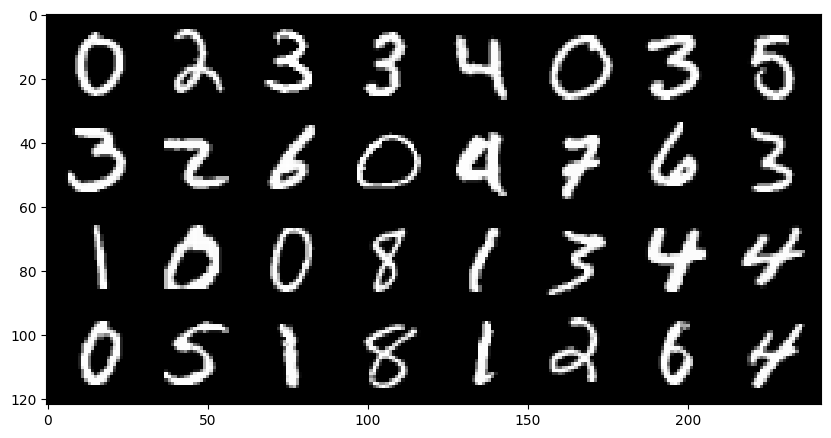

In [6]:
inputs = next(iter(train_loader))[0]
input_grid = utils.make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

In [7]:
def create_convolutional_network():
    """
    This function returns the convolutional network layed out above.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

In [8]:
def poutyne_train(pytorch_network):
    """
    This function creates a Poutyne Model (see https://poutyne.org/model.html), sends the
    Model on the specified device, and uses the `fit_generator` method to train the
    neural network. At the end, the `evaluate_generator` is used on  the test set.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    print(pytorch_network)

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Poutyne Model
    model = Model(pytorch_network, optimizer, loss_function, batch_metrics=['accuracy'])

    # Send model on GPU
    model.to(device)

    # Train
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [9]:
conv_net = create_convolutional_network()
poutyne_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1/1 Train steps: 1500 Val steps: 375 19.20s loss: 0.396201 acc: 87.187500 val_loss: 0.087136 val_acc: 97.375000
Test steps: 313 2.45s test_loss: 0.074455 test_acc: 97.590000                                                   
Test:
	Loss: 0.07445458313710987
	Accuracy: 97.59
